# Play sound and vibrate LRA base on sound 

Play the foot step sound and then using the LRA to mimic the vibration of different sound wave

### 1. Helper Function

In [8]:
import wave
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import pydualsense
import time

def plot_sound(file_path):
    # Plot the sound wave
    wf = wave.open(file_path, 'rb')
    signal = wf.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    framerate = wf.getframerate()
    time = np.linspace(0, len(signal) / framerate, num=len(signal))

    plt.figure(1)
    plt.title(f'Sound Wave - {file_path}')
    plt.plot(time, signal)
    plt.show()

# a function to get the acc data from the dualsense
def get_acc_data(dualsense: pydualsense):
    acc_data_array=[dualsense.status().accelerometer.x,dualsense.status().accelerometer.y,dualsense.status().accelerometer.z]
    return acc_data_array


def play_audio_haptics_with_sensors(dualsense: pydualsense, wav_file_path: str, intensity_scale: float = 1.0):
    """
    Plays a WAV file as haptic feedback while collecting accelerometer data,
    then plots the collected data.
    
    Args:
        dualsense: The DualSense controller instance
        wav_file_path: Path to the WAV file
        intensity_scale: Scale factor for vibration intensity (0.0 to 1.0)
    """
    CHUNK = 1024
    SENSOR_SAMPLE_RATE = 1000  # 1kHz sampling rate
    sensor_interval = 1.0 / SENSOR_SAMPLE_RATE
    
    # Data collection lists
    timestamps = []
    acc_x = []
    acc_y = []
    acc_z = []
    
    # Open the WAV file
    wf = wave.open(wav_file_path, 'rb')
    
    # Initialize PyAudio
    p = pyaudio.PyAudio()
    
    # Create audio stream
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                   channels=wf.getnchannels(),
                   rate=wf.getframerate(),
                   output=True)
    
    print(f"Playing audio and collecting sensor data from {wav_file_path}")
    
    try:
        start_time = time.time()
        last_sensor_read = start_time
        data = wf.readframes(CHUNK)
        
        while len(data) > 0:
            # Play audio
            stream.write(data)
            
            # Convert to numpy array for haptics processing
            audio_data = np.frombuffer(data, dtype=np.int16)
            
            # If stereo, convert to mono
            if wf.getnchannels() == 2:
                audio_data = audio_data.reshape(-1, 2).mean(axis=1)
            
            # Calculate intensity for haptic feedback
            intensity = float(np.mean(np.abs(audio_data)) / np.iinfo(np.int16).max)
            intensity = intensity * intensity_scale
            intensity = max(0.0, min(1.0, intensity))
            
            # Set vibration
            dualsense.setLeftMotor(int(intensity * 255))
            
            # Collect sensor data at specified sampling rate
            current_time = time.time()
            while current_time - last_sensor_read >= sensor_interval:
                acc = dualsense.state.accelerometer
                timestamps.append(current_time - start_time)
                acc_x.append(acc.X)
                acc_y.append(acc.Y)
                acc_z.append(acc.Z)
                last_sensor_read = current_time
                current_time = time.time()
            
            # Read next chunk
            data = wf.readframes(CHUNK)
            
    except KeyboardInterrupt:
        print("\nPlayback interrupted")
    finally:
        # Cleanup
        stream.stop_stream()
        stream.close()
        p.terminate()
        dualsense.setLeftMotor(0)
        wf.close()
    
    # Create a figure with 3 subplots in a row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 6))
    
    # Plot sound wave
    wf = wave.open(wav_file_path, 'rb')
    signal = np.frombuffer(wf.readframes(-1), dtype=np.int16)
    time_audio = np.linspace(0, len(signal) / wf.getframerate(), num=len(signal))
    ax1.plot(time_audio, signal)
    ax1.set_title(f'Audio Waveform\n{wav_file_path}')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True)
    wf.close()

    # Plot accelerometer XYZ data
    ax2.plot(timestamps, acc_x, 'r-', label='X-axis', linewidth=1)
    ax2.plot(timestamps, acc_y, 'g-', label='Y-axis', linewidth=1)
    ax2.plot(timestamps, acc_z, 'b-', label='Z-axis', linewidth=1)
    ax2.set_title(f'Accelerometer XYZ Data\n{wav_file_path}')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Acceleration')
    ax2.grid(True)
    ax2.legend()

    # Plot accelerometer magnitude
    magnitude = np.sqrt(np.array(acc_x)**2 + np.array(acc_y)**2 + np.array(acc_z)**2)
    ax3.plot(timestamps, magnitude, 'k-', label='Magnitude', linewidth=1)
    ax3.set_title(f'Accelerometer Magnitude\n{wav_file_path}')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Acceleration Magnitude')
    ax3.grid(True)
    ax3.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Return collected data for further analysis if needed
    return {
        'timestamps': timestamps,
        'acc_x': acc_x,
        'acc_y': acc_y,
        'acc_z': acc_z
    }

# Usage example:
# dualsense = pydualsense.pydualsense()
# dualsense.init()
# sensor_data = play_audio_haptics_with_sensors(dualsense, footstep_sound1)
# dualsense.close()




In [4]:
#  play example sound 

footstep_sound1 = "./sound/footsteps-1.wav"
footstep_sound2 = "./sound/footsteps-5.wav"
footstep_sound3_snow = "./sound/walking-in-snow-1.wav"
footstep_sound4_woodenstairs = "./sound/wooden-stairs-2.wav"

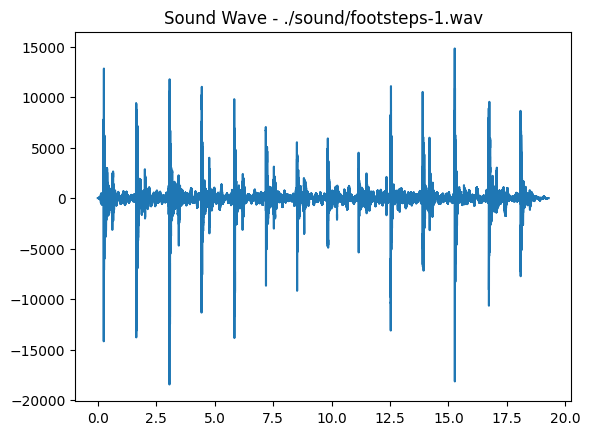

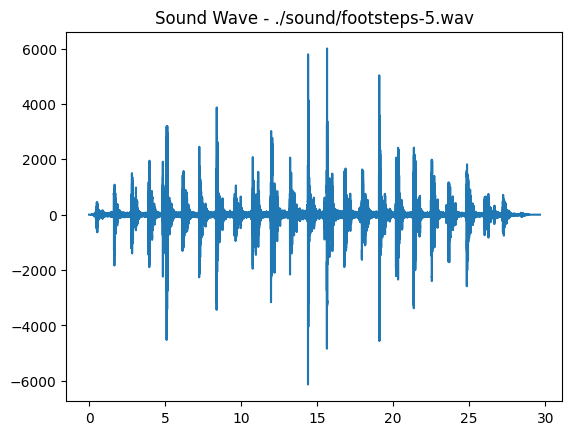

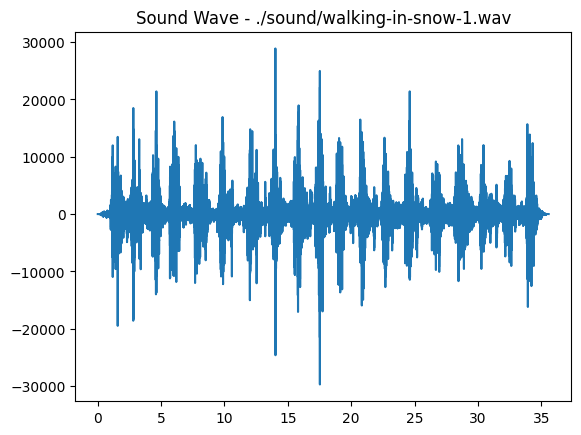

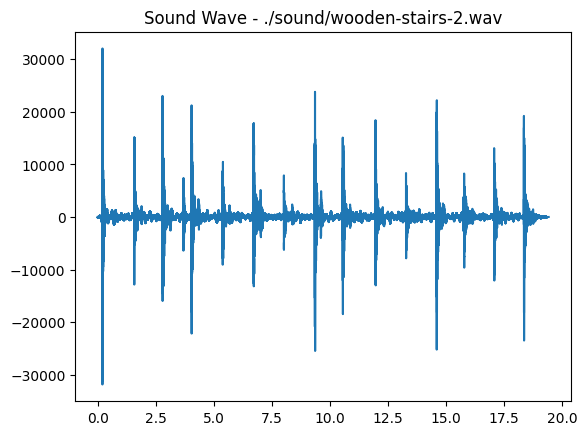

In [10]:
for sound in [footstep_sound1, footstep_sound2, footstep_sound3_snow, footstep_sound4_woodenstairs]:
    plot_sound(sound)

Playing audio and collecting sensor data from ./sound/footsteps-1.wav


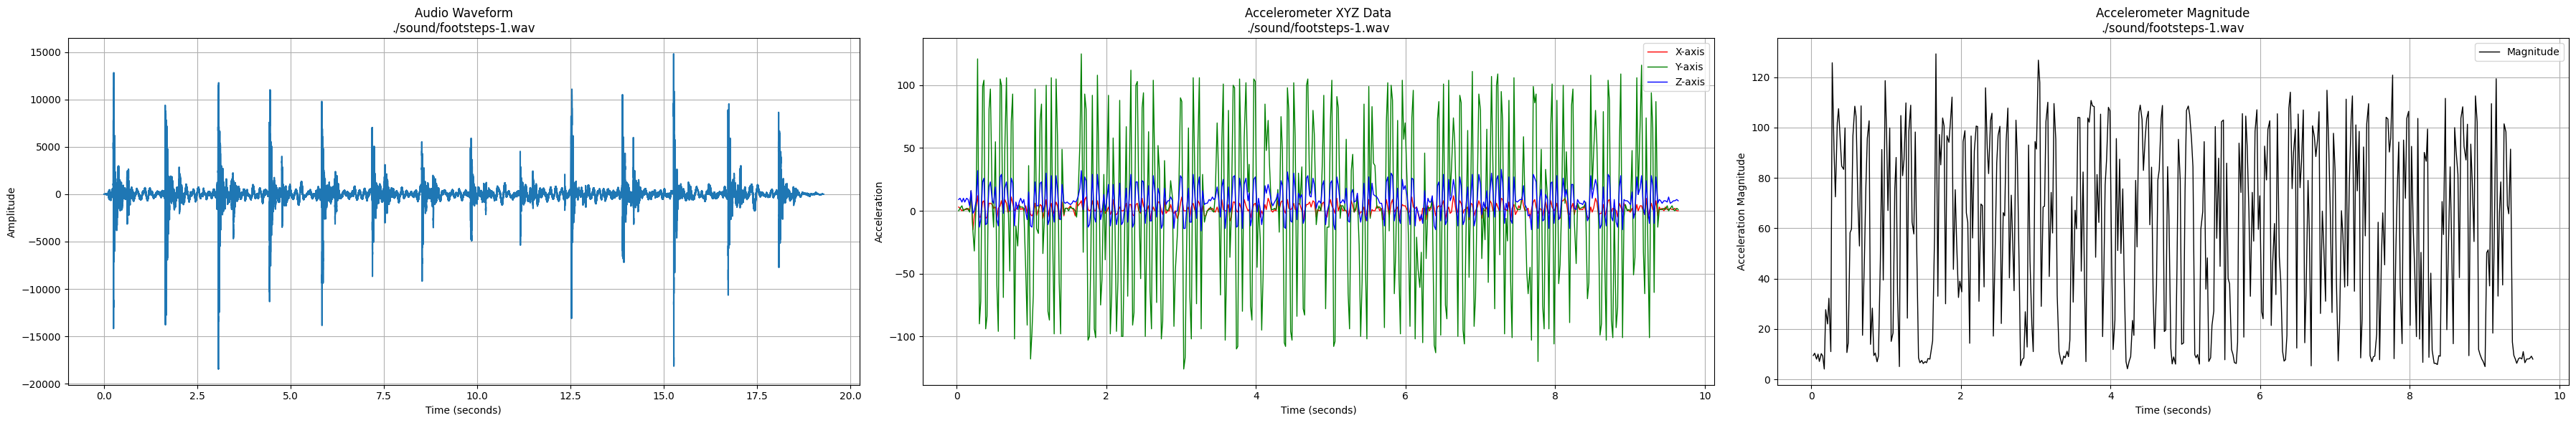

Playing audio and collecting sensor data from ./sound/footsteps-5.wav


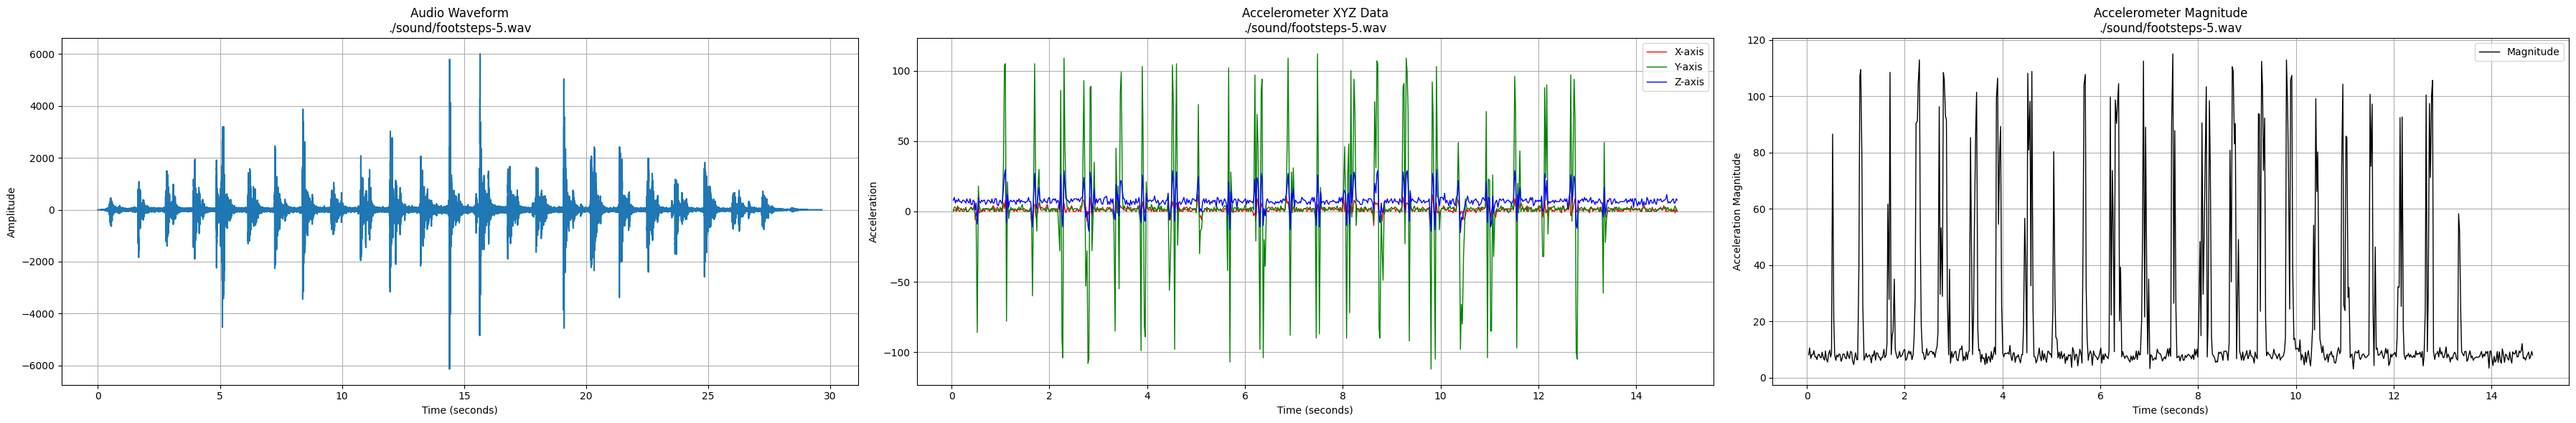

Playing audio and collecting sensor data from ./sound/walking-in-snow-1.wav


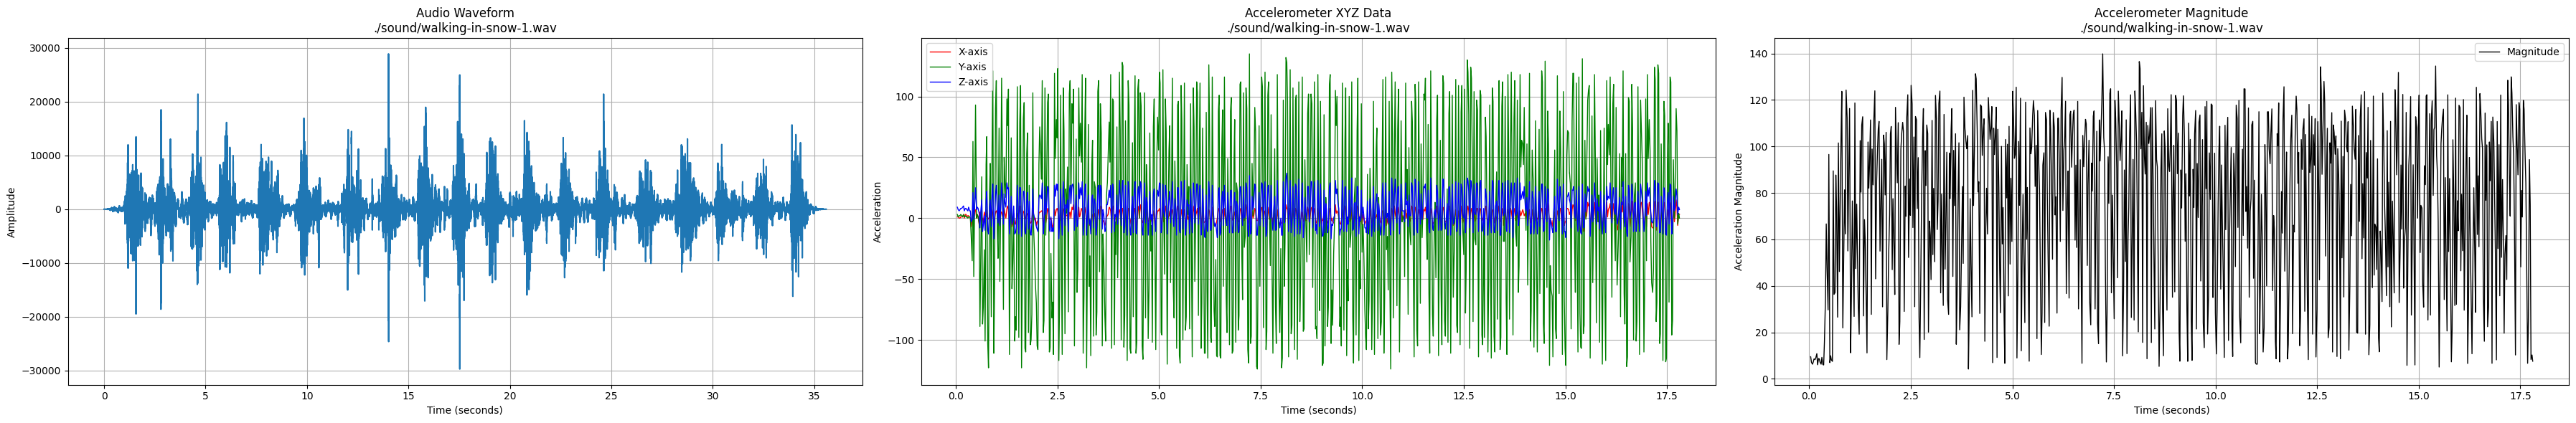

Playing audio and collecting sensor data from ./sound/wooden-stairs-2.wav


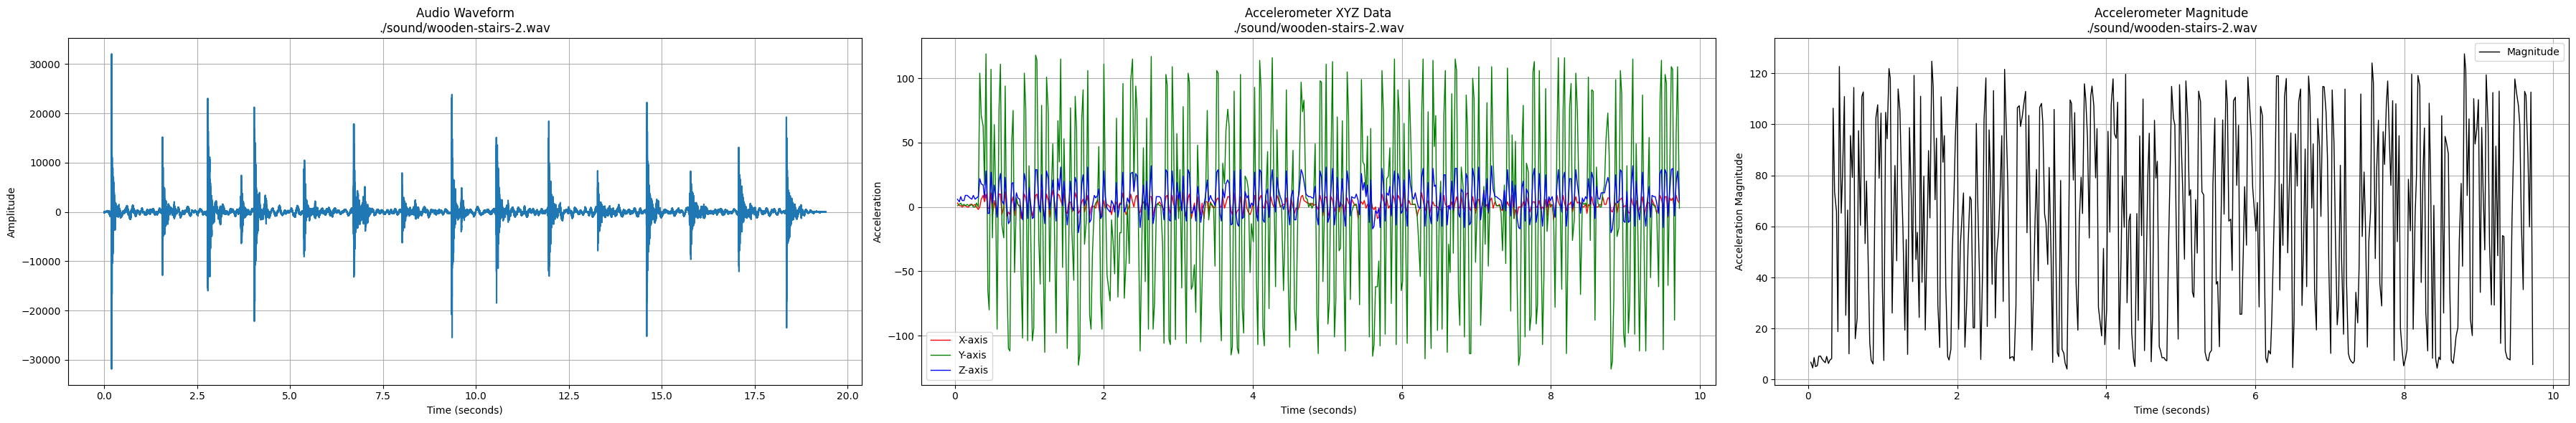

In [9]:
dualsense = pydualsense.pydualsense()
dualsense.init()

play_audio_haptics_with_sensors(dualsense, footstep_sound1, intensity_scale=1.0)
play_audio_haptics_with_sensors(dualsense, footstep_sound2, intensity_scale=1.0)
play_audio_haptics_with_sensors(dualsense, footstep_sound3_snow, intensity_scale=1.0)
play_audio_haptics_with_sensors(dualsense, footstep_sound4_woodenstairs, intensity_scale=1.0)

dualsense.close()